In [1]:
"""
Read the survey data

"""
# Reload libraries automatically so that we can modify them and see the changes
%load_ext autoreload
%autoreload 2

from ema import read

# There's LOADS of columns here, and some of them contain a mix of numbers and strings
# I don't actually care about most of these columns but it isn't a big overhead so we'll just
# carry them around anyway
qnaire_answers = read._qnaire_df()

/home/mh19137/seaco_malaysia/ema/read.py:57: DtypeWarning: Columns (17,25,26,52,197,198,200,201,209,210,212,213,216,218,219,222,225,227,228,230,231,233,234,236,237,239,240,243,246,248,249,252,254,255,257,258,261,263,264,267,269,270,272,273,276,279,281,284,291,293,294,296,297,300,302,303,305,306,309,311,312,314,315,317,318,321,324,327,330,344,351,352,354,355,360,361,362,363,364,369,370,371,372,373,378,379,380,381,382,387,390,391,396,397,398,399,400,406,407,415,425,432,434,435,436,446,456,486,499,504,506,512,513,549) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path)


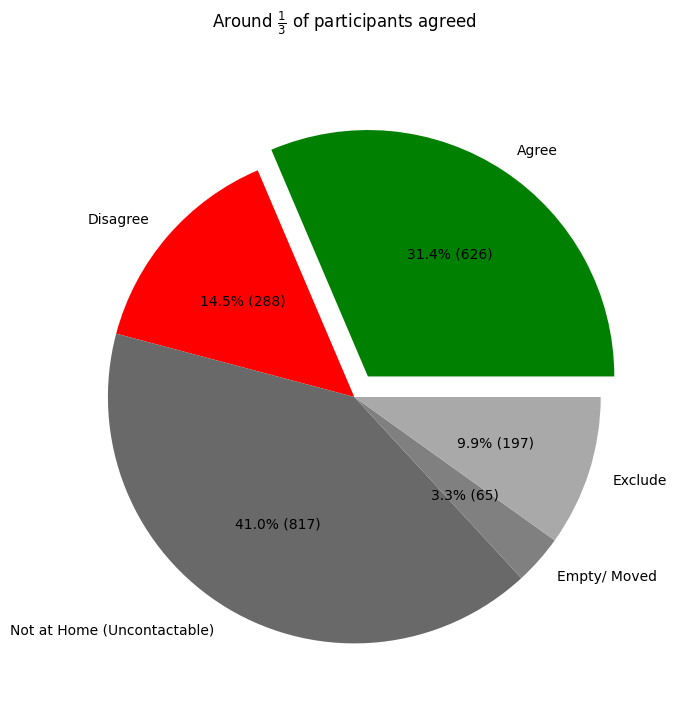

In [2]:
""" Make a pie chart showing how many people accepted """
import numpy as np
import matplotlib.pyplot as plt

# Count how many people in each category
response_codes, counts = np.unique(
    qnaire_answers["respondent_status"], return_counts=True
)

response_lookup = read.qnaire_status_codebook()

labels = [response_lookup[code] for code in response_codes]

colours = ["green", "red", "dimgrey", "grey", "darkgrey", "lightgrey"]
percentages = [count / np.sum(counts) for count in counts]


# Display both the percentage and count in the pie chart labels
def pct_and_count(values: list):
    """Returns callable"""

    def formatted_pct(pct: float):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f"{pct:.1f}% ({val:d})"

    return formatted_pct


fig, axis = plt.subplots(figsize=(8, 8))
axis.pie(
    counts,
    explode=[0.1, *[0.0] * (len(counts) - 1)],
    labels=labels,
    colors=colours,
    autopct=pct_and_count(counts),
)

fig.suptitle(r"Around $\frac{1}{3}$ of participants agreed")
fig.savefig("img/responses.png")

In [3]:
"""
We only have more detailed demographic information for the participants who agreed to take part; so just
drop everyone else from the dataframe.

"""
qnaire_answers = qnaire_answers[qnaire_answers["respondent_status"] == 1]

In [4]:
"""
We also want to track the ages, but want to bin them into groups

Here we'll create a new column in the dataframe called `age_group`, and then populate it with an integer indicating
which age group they're in

"""
qnaire_answers["age_group"] = 0
age_bins = (7, 10, 13, 16)

age_col = qnaire_answers.loc[:, "age_dob"]

for age in age_bins[1:]:
    qnaire_answers.loc[age_col >= age, "age_group"] += 1


def age_group_codebook():
    """Translate age group int into something human readable"""
    return {
        0: f"{age_bins[0]}-{age_bins[1] - 1}",
        1: f"{age_bins[1]}-{age_bins[2] - 1}",
        2: f"{age_bins[2]}-{age_bins[3] - 1}",
        3: f"{age_bins[3]}+",
    }


# Just print some information
print(qnaire_answers["age_group"].value_counts().sort_index())
print(qnaire_answers["age_dob"].value_counts().sort_index())

age_group
0    109
1    178
2    208
3    131
Name: count, dtype: int64
age_dob
7.0      5
8.0     41
9.0     63
10.0    60
11.0    57
12.0    61
13.0    75
14.0    57
15.0    76
16.0    63
17.0    67
18.0     1
Name: count, dtype: int64


/tmp/ipykernel_19712/2339004247.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qnaire_answers["age_group"] = 0


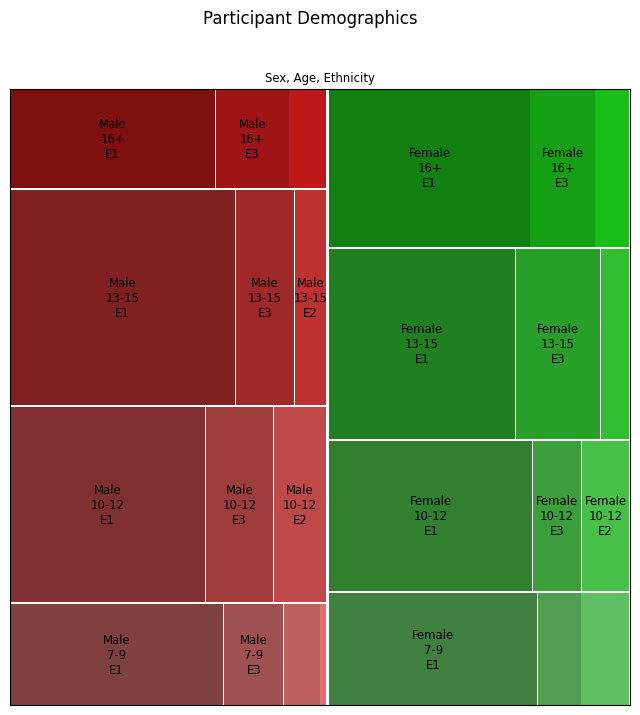

In [5]:
from statsmodels.graphics.mosaicplot import mosaic

from importlib import reload

reload(read)


def labelizer(key):
    """Generate a label for the mosaic plot"""
    sex, age_group, ethnicity = (
        float(x) for x in key
    )  # Convert the string keys to floats
    sex_codebook = read.qnaire_sex_codebook()
    age_codebook = age_group_codebook()
    ethnicity_codebook = read.qnaire_ethnicity_codebook()

    # If there aren't many in this category, don't bother labelling it
    count_in_box = np.sum(
        np.logical_and.reduce(
            [
                qnaire_answers["respondent_sex"].values == sex,
                qnaire_answers["age_group"].values == age_group,
                qnaire_answers["respondent_ethnicity"].values == ethnicity,
            ],
        )
    )
    if count_in_box < 10:
        return ""

    return f"{sex_codebook[sex]}\n{age_codebook[age_group]}\n{ethnicity_codebook[ethnicity]}"


fig, axis = plt.subplots(figsize=(8, 8))
_, stuff = mosaic(
    qnaire_answers.sort_values("age_group"),
    ["respondent_sex", "age_group", "respondent_ethnicity"],
    labelizer=labelizer,
    axes_label=False,
    ax=axis,
)

fig.suptitle("Participant Demographics")
axis = fig.axes[0]
axis.set_title("Sex, Age, Ethnicity", fontsize="small")
fig.savefig("img/demographics.png")

[0.0, 0.0005, 491.0405, 16.562]
[0.0, 0.002, 0.648, 645.248]
[0.0, 0.008, 2.048, 611.618]
[0.0005, 0.2645, 66.248, 308.898]


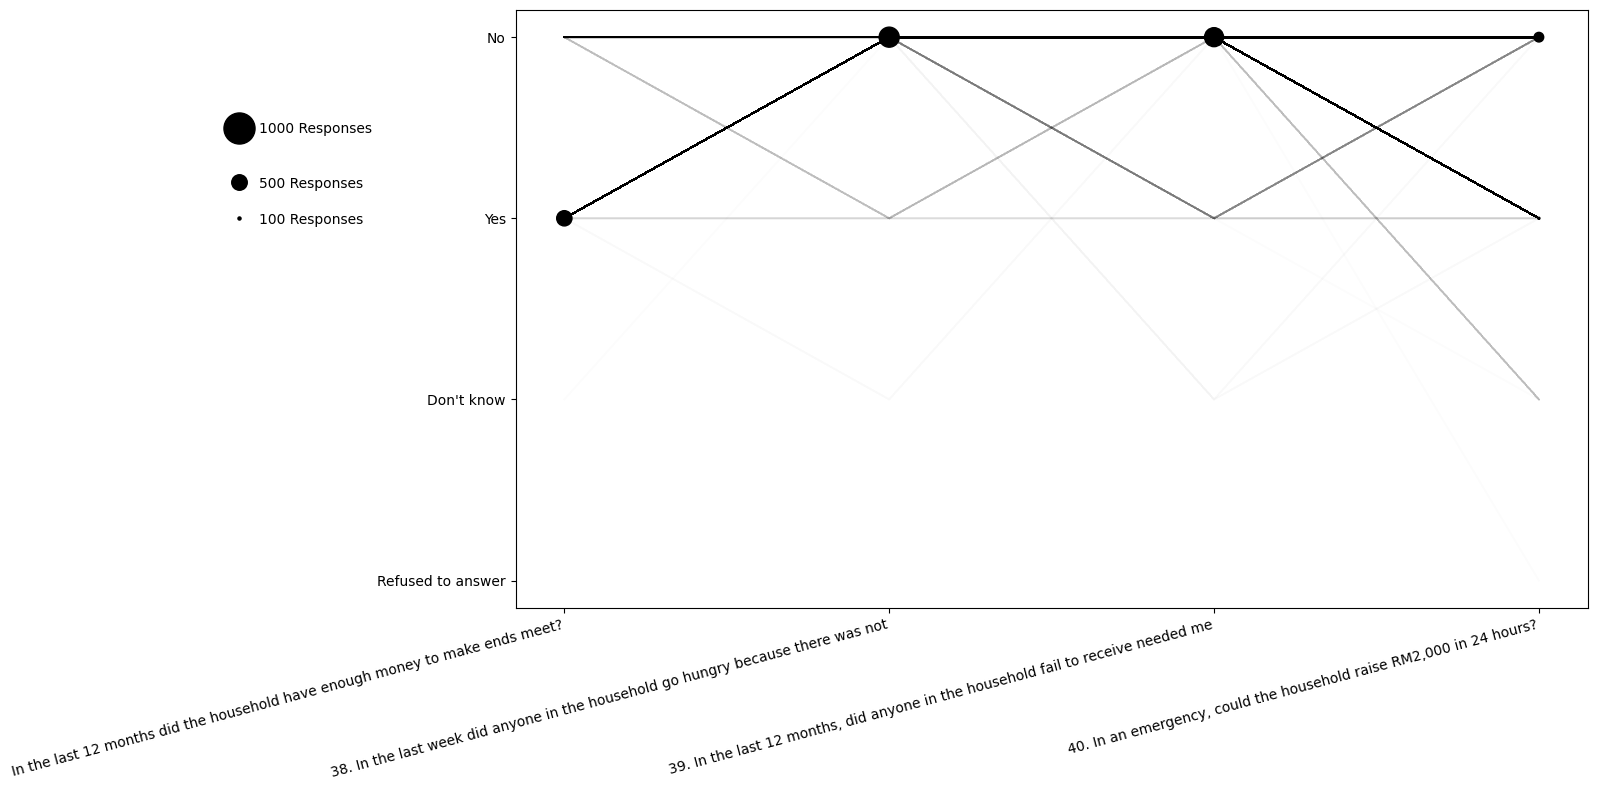

In [6]:
""" Income survey responses """
from matplotlib.patches import Circle

income_df = read.income_data()

# Convert every response to an array of numbers
answer_matrix = income_df[[f"income_{i}" for i in range(1, 5)]].to_numpy()

# Show relationship between answers
fig, axis = plt.subplots(figsize=(16, 8))

income_codebook = read.income_codebook()
labels = [income_codebook[f"income_{i}"]["q"] for i in range(1, 5)]

# Convert the answer matrix into something nicer for plotting
answer_matrix[answer_matrix == -9.0] = -1.0  # Refused to answer
answer_matrix[answer_matrix == -8.0] = 0.0  # Don't know

# Plot lines connecting the common answers
for row in answer_matrix:
    axis.plot(row, alpha=0.01, color="k")


# Plot a scatter showing the the relative frequency of each answer
def circle_size(n):
    return 0.0005 * n**2


for i, column in enumerate(answer_matrix.T):
    vals = [-1.0, 0.0, 1.0, 2.0]
    sizes = [circle_size(np.sum(column == val)) for val in vals]

    axis.scatter([i] * 4, vals, s=[circle_size(size) for size in sizes], color="k")
    print(sizes)

plt.autoscale(False)


def legend(n, x, y):
    axis.scatter(x, y, s=circle_size(n), color="k", label="100", clip_on=False)
    axis.text(x + 0.06, y - 0.03, f"{n} Responses")


legend(1000, -1.0, 1.5)
legend(500, -1.0, 1.2)
legend(100, -1.0, 1.0)

axis.set_yticks([-1, 0, 1, 2], ["Refused to answer", "Don't know", "Yes", "No"])
axis.set_xticks(range(4), labels, rotation=15, ha="right")

fig.tight_layout()

fig.savefig("img/income.png")